In [1]:
from __future__ import print_function
from __future__ import division
import os, sys
import numpy as np
import pandas as pd
from scipy.signal import medfilt
from builtins import range
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score
import mir_eval
import librosa, librosa.display
import matplotlib.pyplot as plt
% matplotlib inline

import tensorflow as tf
import keras
from keras.models import Sequential, Model
from keras.layers import Activation, Dense, Flatten, Input, Reshape, Dropout, Permute
from keras.layers.convolutional import Conv2D
from keras.layers.normalization import BatchNormalization
from keras.layers.recurrent import GRU
from keras.layers.pooling import MaxPooling2D, GlobalAveragePooling2D
from keras.layers.merge import Concatenate
from keras import backend as K
from keras.backend.tensorflow_backend import set_session

os.environ["CUDA_VISIBLE_DEVICES"]="0" # the number of the GPU
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.3 # percentage to be used
set_session(tf.Session(config=config))

from kapre.time_frequency import Melspectrogram
from global_config import *


Using TensorFlow backend.


Channel-last, i.e., (None, n_freq, n_time, n_ch)


In [2]:
def model_multi_kernel_shape(n_out, input_shape, out_activation='softmax'):
    """

    Symbolic summary:
    > c2' - p2 - c2 - p2 - c2 - p2 - c2 - p3 - d1
    where c2' -> multiple kernel shapes

    Parameters
    ----------
        n_out: integer, number of output nodes
        input_shape: tuple, an input shape, which doesn't include batch-axis.
        out_activation: activation function on the output
    """
    audio_input = Input(shape=input_shape)

    x = Melspectrogram(n_dft=N_FFT, n_hop=HOP_LENGTH, sr=SR, n_mels=128, power_melgram=2.0, return_decibel_melgram=True)(audio_input)
    x = BatchNormalization(axis=channel_axis)(x)

    x1 = Conv2D(7, (20, 3), padding='same', kernel_regularizer=keras.regularizers.l2(reg_w))(x)
    x2 = Conv2D(7, (3, 3), padding='same', kernel_regularizer=keras.regularizers.l2(reg_w))(x)
    x3 = Conv2D(7, (3, 20), padding='same', kernel_regularizer=keras.regularizers.l2(reg_w))(x)

    x = Concatenate(axis=channel_axis)([x1, x2, x3])

    x = BatchNormalization(axis=channel_axis)(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Dropout(0.25)(x)
    
    x = Conv2D(21, (3, 3), padding='same', kernel_regularizer=keras.regularizers.l2(reg_w))(x)
    x = BatchNormalization(axis=channel_axis)(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Dropout(0.25)(x)

    x = Conv2D(21, (3, 3), padding='same', kernel_regularizer=keras.regularizers.l2(reg_w))(x)
    x = BatchNormalization(axis=channel_axis)(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Dropout(0.25)(x)

    x = Conv2D(21, (3, 3), padding='same', kernel_regularizer=keras.regularizers.l2(reg_w))(x)
    x = BatchNormalization(axis=channel_axis)(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((4, 4), padding='same')(x)
    x = Dropout(0.25)(x)

    x = GlobalAveragePooling2D()(x)

    out = Dense(n_out, activation=out_activation, kernel_regularizer=keras.regularizers.l2(reg_w))(x)

    model = Model(audio_input, out)

    return model

def data_gen(audio_data, n_detect, nsp_excerpt, type_excerpt, hop_length=HOP_LENGTH):
    """Data generator.
    excerpt: data of one audio file.
    n_detect: number of excerpts to be detected.
    nsp_detect: number of samples in one excerpt.
    """
    
    tile_times = int(np.ceil(NSP_SRC/nsp_excerpt))

    while True:
        for i in range(n_detect):
            
            if type_excerpt == 'onset':
                src_batch = np.array([audio_data[int(i*hop_length):int(i*hop_length+nsp_excerpt)]], dtype=K.floatx())
            elif type_excerpt == 'segment':
                src_batch = np.array([np.tile(audio_data[int(i*hop_length):int(i*hop_length+nsp_excerpt)],tile_times)[:NSP_SRC]],
                                     dtype=K.floatx())
                
            src_batch = src_batch[:, np.newaxis, :]  # make (batch, N) to (batch, 1, N) for kapre compatible
            
            yield src_batch
            
    
def segframes2intervals(segframes, paudio_duration):
    idx2del = []
    for idx in np.arange(1,len(segframes)):
        if segframes[idx-1][1] >= segframes[idx][0]:
            segframes[idx] = [segframes[idx-1][0],segframes[idx][1]]
            idx2del.append(idx-1)           
    segframes = np.delete(segframes, idx2del, axis=0)  
    
    labels = []
    segintervals = np.zeros((len(segframes)*2+1,2))
    
    for idx in range(len(segintervals)):
        if idx==0:
            segintervals[idx] = [0, segframes[0][0]]
            labels.append('np')
        elif idx==len(segintervals)-1:
            segintervals[idx] = [segframes[-1][-1],paudio_duration]
            labels.append('np')
        elif idx%2:
            segintervals[idx] = segframes[int(np.floor(idx/2))]
            labels.append('p')
        else:
            segintervals[idx] = [segframes[int(np.floor(idx/2)-1)][-1],segframes[int(np.floor(idx/2))][0]]
            labels.append('np')
            
    idx2del = []
    for idx, seginterval in enumerate(segintervals):
        if seginterval[0]==seginterval[1]:
            idx2del.append(idx)
    segintervals = np.delete(segintervals, idx2del, axis=0)
    labels = np.delete(labels, idx2del)
    
    return segintervals, labels

In [3]:
dataset_name = 'pedal-times_test.npz'
model_name = 'multi_kernel'

segment_exp_name = 'segment_{}'.format(model_name)
onset_exp_name = 'onset_{}'.format(model_name)
reg_w = 1e-4
batch_size = 1

onset_threshold = 0.98
segment_threshold = 0.98

print("-" * 60)
print("Beici: Welcome! Lets do pedal segment detection on a music piece.")
print("       We're gonna use {} model.".format(model_name))
npz_path = os.path.join(DIR_PEDAL_METADATA, dataset_name)
tracks = np.load(npz_path)
filenames = tracks['filename']
pedal_offset_gt_tracks = tracks['pedal_offset']
pedal_onset_gt_tracks = tracks['pedal_onset']

print("Beici: Getting model...")
onset_model = model_multi_kernel_shape(n_out=2,input_shape=ONSET_INPUT_SHAPE)
onset_model.compile('adam', 'categorical_crossentropy', metrics=['accuracy'])
segment_model = model_multi_kernel_shape(n_out=2,input_shape=SEGMENT_INPUT_SHAPE)
segment_model.compile('adam', 'categorical_crossentropy', metrics=['accuracy'])
print("       Loading the best weights...")
onset_model.load_weights(os.path.join(DIR_SAVE_MODEL,"{}_best_weights.h5".format(onset_exp_name)))
segment_model.load_weights(os.path.join(DIR_SAVE_MODEL,"{}_best_weights.h5".format(segment_exp_name)))

------------------------------------------------------------
Beici: Welcome! Lets do pedal segment detection on a music piece.
       We're gonna use multi_kernel model.
Beici: Getting model...
       Loading the best weights...


In [6]:
# for idx, filename in enumerate(filenames):
filename_idx = 30
filename = filenames[filename_idx]    
print(filename)
paudio_path = os.path.join(DIR_RENDERED, '{}-p.wav'.format(filename))
paudio, sr = librosa.load(paudio_path, sr=SR) 
pedal_offset_gt = np.array(pedal_offset_gt_tracks[filename_idx])
pedal_onset_gt = np.array(pedal_onset_gt_tracks[filename_idx])

2011/Guo01


In [5]:
print("Beici: Predicting...")
len_onset_shape = int(SR * (TRIM_SECOND_BEFORE + TRIM_SECOND_AFTER))
onsethop_length = HOP_LENGTH
onsethop_duration = onsethop_length/SR
n_ponset = int(np.ceil((len(paudio)-len_onset_shape)/onsethop_length))
gen_ponset = data_gen(paudio, n_ponset, len_onset_shape, 'onset', hop_length=onsethop_length)
pred_ponset = onset_model.predict_generator(gen_ponset, n_ponset // batch_size)
pred_ponset_filter = medfilt(pred_ponset[:,1],15)
frmtime_ponset = np.arange(n_ponset)*onsethop_duration+TRIM_SECOND_BEFORE

len_segment_shape = int(SR * MIN_SRC)
seghop_length = HOP_LENGTH*10
seghop_duration = seghop_length/SR
n_psegment = int(np.ceil((len(paudio)-len_segment_shape)/seghop_length))
gen_psegment = data_gen(paudio, n_psegment, len_segment_shape, 'segment', hop_length=seghop_length)
pred_psegment = segment_model.predict_generator(gen_psegment, n_psegment // batch_size)
pred_psegment_filter = medfilt(pred_psegment[:,1],3)
frmtime_psegment = np.arange(n_psegment)*seghop_duration+MIN_SRC/2
paudio_firstonsettime = librosa.frames_to_time(librosa.onset.onset_detect(y=paudio, sr=SR), sr=SR)[0]
n_segment_tozero=0
for t in frmtime_psegment:
    if t < paudio_firstonsettime:
        n_segment_tozero+=1
    else:
        break        
pred_psegment_filter[:n_segment_tozero] = 0

pred_ponset_todetect = np.copy(pred_ponset_filter)
pred_ponset_todetect[pred_ponset_todetect<onset_threshold]=0
pred_ponset_todetect[pred_ponset_todetect>=onset_threshold]=1

pred_psegment_todetect = np.copy(pred_psegment_filter)
pred_psegment_todetect[pred_psegment_todetect<segment_threshold]=0
pred_psegment_todetect[pred_psegment_todetect>=segment_threshold]=1

Beici: Predicting...


In [8]:
# # predict for non-pedal version
# npaudio_path = os.path.join(DIR_RENDERED, '{}-np.wav'.format(filename))
# npaudio, sr = librosa.load(npaudio_path, sr=SR)

# n_nponset = int(np.ceil((len(npaudio)-len_onset_shape)/onsethop_length))
# gen_nponset = data_gen(npaudio, n_nponset, len_onset_shape, 'onset', hop_length=onsethop_length)
# pred_nponset = onset_model.predict_generator(gen_nponset, n_nponset // batch_size)
# pred_nponset_filter = medfilt(pred_nponset[:,1],15)
# frmtime_nponset = np.arange(n_nponset)*onsethop_duration+TRIM_SECOND_BEFORE

# n_npsegment = int(np.ceil((len(npaudio)-len_segment_shape)/seghop_length))
# gen_npsegment = data_gen(npaudio, n_npsegment, len_segment_shape, 'segment', hop_length=seghop_length)
# pred_npsegment = segment_model.predict_generator(gen_npsegment, n_npsegment // batch_size)
# pred_npsegment_filter = medfilt(pred_npsegment[:,1],3)
# frmtime_npsegment = np.arange(n_npsegment)*seghop_duration+MIN_SRC/2

In [9]:
# decide the initial indexes of pedal segment boundary
onseg_initidxs = []
offseg_initidxs = []
for idx, v in enumerate(pred_psegment_todetect):
    if idx>0 and idx<len(pred_psegment_todetect)-1:
        if pred_psegment_todetect[idx-1]==0 and v==1 and pred_psegment_todetect[idx+1]==1:
            onseg_initidxs.append(idx-1)
        elif pred_psegment_todetect[idx-1]==1 and v==1 and pred_psegment_todetect[idx+1]==0:
            offseg_initidxs.append(idx+1)

In [10]:
if offseg_initidxs[0] <= onseg_initidxs[0]:
    del offseg_initidxs[0]
if onseg_initidxs[-1] >= offseg_initidxs[-1]:
    del onseg_initidxs[-1]

In [16]:
if (len(onseg_initidxs) != len(offseg_initidxs)) or not len(pedal_offset_gt) or not len(pedal_onset_gt):
    print(" skip!")
else:
    onseg_idxs = []
    offseg_idxs = []
    for idx in range(len(onseg_initidxs)):
        if onseg_initidxs[idx] < offseg_initidxs[idx]:
            onseg_idxs.append(onseg_initidxs[idx])
            offseg_idxs.append(offseg_initidxs[idx])
    
    if not len(onseg_idxs) or not len(offseg_idxs):
        print("  no detection!")

 skip!


In [17]:
# decide the boundary times in seconds, combining the effect of pedal onset
onseg_times = []
offseg_times = []
for idx, onseg_idx in enumerate(onseg_idxs):
    onponset_idx = onseg_idx*10-5
    if any(pred_ponset_todetect[onponset_idx-5:onponset_idx+5]):
        offseg_idx = offseg_idxs[idx]
        offseg_times.append(frmtime_psegment[offseg_idx])
        onseg_times.append(frmtime_psegment[onseg_idx])
segintervals_est = np.stack((np.asarray(onseg_times),np.asarray(offseg_times)), axis=-1)

In [26]:
# set the ground truth and estimation results frame by frame
paudio_duration = librosa.get_duration(y=paudio, sr=SR)
n_frames = int(np.ceil(paudio_duration/seghop_duration))
segframes_gt = np.zeros(n_frames)
segframes_est = np.zeros(n_frames)

longpseg_idx = np.where((pedal_offset_gt-pedal_onset_gt)>seghop_duration)[0]
longseg_onset_gt = pedal_onset_gt[longpseg_idx]
longseg_offset_gt = pedal_offset_gt[longpseg_idx]
segintervals_gt = np.stack((longseg_onset_gt,longseg_offset_gt), axis=-1)

for idx, onset_t in enumerate(longseg_onset_gt):
    offset_t = longseg_offset_gt[idx]
    onset_frm = int(onset_t//seghop_duration)
    offset_frm = int(offset_t//seghop_duration)
    segframes_gt[onset_frm:offset_frm] = 1

for idx, onset_t in enumerate(onseg_times):
    offset_t = offseg_times[idx]
    onset_frm = int(onset_t//seghop_duration)
    offset_frm = int(offset_t//seghop_duration)
    segframes_est[onset_frm:offset_frm] = 1   

In [27]:
# set the ground truth and estimation results as interval format
segintervals01_gt, labels_gt = segframes2intervals(segintervals_gt, paudio_duration)
segintervals01_est, labels_est = segframes2intervals(segintervals_est, paudio_duration)

In [28]:
paudio_duration = librosa.get_duration(y=paudio, sr=SR)
paudio_duration

158.0408163265306

In [29]:
for i in range(len(segintervals01_gt)):
    if segintervals01_gt[i][1]<=segintervals01_gt[i][0]:
        print(segintervals01_gt[i])

In [30]:
# Metrics for frame-wise label 'p'
acc1_frm = accuracy_score(segframes_gt,segframes_est)
p1_frm, r1_frm, f1_frm, support = precision_recall_fscore_support(segframes_gt,segframes_est)
tn, fp, fn, tp = confusion_matrix(segframes_gt,segframes_est).ravel()
fp_rate = fp/(fp+tn)
fn_rate = fn/(fn+tp)

# performance matrix based on boundary annotation
# window depends on duration of a beat
onset_env = librosa.onset.onset_strength(paudio, sr=SR)
tempo = librosa.beat.tempo(onset_envelope=onset_env, sr=SR)[0]
beat_insecond = 60/tempo
p_sbr,r_sbr,f_sbr = mir_eval.segment.detection(segintervals01_gt, segintervals01_est, window=beat_insecond)

# performance matrix based on structural annotation
scores = mir_eval.segment.evaluate(segintervals01_gt, labels_gt, segintervals01_est, labels_est)
r2e_deviation, e2r_deviation = [scores['Ref-to-est deviation'], scores['Est-to-ref deviation']]
p_pairwise, r_pairwise, f_pairwise = [scores['Pairwise Precision'], scores['Pairwise Recall'], 
                                      scores['Pairwise F-measure']]
rand_index, adjrand_index = [scores['Rand Index'], scores['Adjusted Rand Index']]
mutual_info, adjmutual_info, normmutual_info = [scores['Mutual Information'], scores['Adjusted Mutual Information'], 
                                                scores['Normalized Mutual Information']]
nce_over, nce_under, nce_f = [scores['NCE Over'], scores['NCE Under'], scores['NCE F-measure']]

In [31]:
print("=" * 60)
print("Metrics for frame-wise label 'p' of {}".format(filename))
print("-" * 50)
print("            Accuracy: {0:.4f}".format(acc1_frm))
print("           Precision: {0:.4f}".format(p1_frm[1]))
print("              Recall: {0:.4f}".format(r1_frm[1]))
print("                  F1: {0:.4f}".format(f1_frm[1]))
print("             FP rate: {0:.4f}".format(fp_rate))
print("             FN rate: {0:.4f}".format(fn_rate))
print("=" * 60)
print("Metrics for boundary annotation of {}".format(filename))
print("-" * 50)
print("     Boundary Window: {0:.4f} seconds".format(beat_insecond))
print("           Precision: {0:.4f}".format(p_sbr))
print("              Recall: {0:.4f}".format(r_sbr))
print("           F-measure: {0:.4f}".format(f_sbr))
print("Ref-to-est deviation: {0:.4f}".format(r2e_deviation))
print("Est-to-ref deviation: {0:.4f}".format(e2r_deviation))
print("=" * 60)
print("Metrics for structural annotation of {}".format(filename))
print("-" * 50)
print("            NCE Over: {0:.4f}".format(nce_over))
print("           NCE Under: {0:.4f}".format(nce_under))
print("  Pairwise Precision: {0:.4f}".format(p_pairwise))
print("     Pairwise Recall: {0:.4f}".format(r_pairwise))
print("  Pairwise F-measure: {0:.4f}".format(f_pairwise))
print("          Rand Index: {0:.4f}".format(rand_index))

Metrics for frame-wise label 'p' of 2011/Colafelice04
--------------------------------------------------
            Accuracy: 0.7881
           Precision: 0.8873
              Recall: 0.6792
                  F1: 0.7694
             FP rate: 0.0937
             FN rate: 0.3208
Metrics for boundary annotation of 2011/Colafelice04
--------------------------------------------------
     Boundary Window: 0.4876 seconds
           Precision: 0.8732
              Recall: 0.3690
           F-measure: 0.5188
Ref-to-est deviation: 0.2370
Est-to-ref deviation: 0.0436
Metrics for structural annotation of 2011/Colafelice04
--------------------------------------------------
            NCE Over: 0.3134
           NCE Under: 0.2848
  Pairwise Precision: 0.6597
     Pairwise Recall: 0.6856
  Pairwise F-measure: 0.6724
          Rand Index: 0.6656


(0, 20)

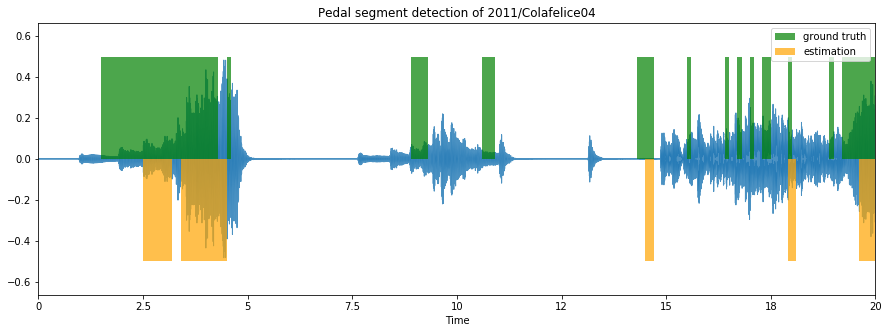

In [32]:
# plot result
frmtimes = np.arange(n_frames)*seghop_duration
left,right = [0,20]
plt.figure(figsize=(15,5))
librosa.display.waveplot(paudio, SR, alpha=0.8)
plt.fill_between(frmtimes, 0, 0.5, where=segframes_gt>0, facecolor='green', alpha=0.7, label='ground truth')
plt.fill_between(frmtimes, -0.5, 0, where=segframes_est>0, facecolor='orange', alpha=0.7, label='estimation')
plt.title("Pedal segment detection of {}".format(filename))
plt.legend()
plt.xlim([left,right])

In [ ]:
# paudio_rmse = librosa.feature.rmse(y=paudio, hop_length=HOP_LENGTH)
# paudio_rmse_norm = (paudio_rmse[0]-min(paudio_rmse[0]))/(max(paudio_rmse[0])-min(paudio_rmse[0]))
# paudio_rmse_norm_filter = medfilt(paudio_rmse_norm,11)
# frmtime_rmse = np.arange(len(paudio_rmse_norm))*0.01

# plt.figure(figsize=(20,8))
# axes = plt.gca()
# ymin, ymax = axes.get_ylim()
# # plt.axhline(0.98, label='seg threshold', color='gray')
# plt.vlines(pedal_onset_gt,ymin, ymax, label='gt onset', color='yellow', lw=2)
# plt.vlines(longseg_onset_gt, ymin, ymax, label='gt long onset', color='red', lw=2)
# plt.vlines(longseg_onset_gt+0.3, ymin, ymax, linestyles='dashed', color='black', lw=1)
# plt.vlines(pedal_offset_gt, ymin, ymax, label='gt offset', color='black', lw=2)
# plt.plot(frmtime_ponset, pred_ponset_todetect, '-', label='predicted pedal onset', alpha=0.7)
# plt.plot(frmtime_psegment, pred_psegment_todetect, '-', label='predicted pedal segment', alpha=0.5)
# for idx in range(len(onseg_times)):S
#     plt.axvspan(onseg_times[idx],offseg_times[idx], ymin, ymax, color='green', alpha=0.3)
# # plt.grid(True)
# # axes.minorticks_on()
# # axes.grid(which='minor')
# # plt.ylim([0.5,1])
# plt.xlim([150,170])
# plt.legend()

In [42]:
# do detection
pedal_offset_gt_tracks = tracks['pedal_offset']
pedal_onset_gt_tracks = tracks['pedal_onset']
# records
filename_records = []
accuracys = []
precisions = []
recalls = []
fscores = []
support0s = []
support1s = []
fp_rates = []
fn_rates = []
# append to lists
filename_records = []
support0s = []
support1s = []
acc1_frms = []
p1_frms = []
r1_frms = []
f1_frms = []
fp_rates = []
fn_rates = []
# boundary matrixs
boundary_wins = []
p_sbrs = []
r_sbrs = []
f_sbrs = []
r2e_deviations = []
e2r_deviations = []
# structural matrixs
p_pairwises = []
r_pairwises = []
f_pairwises = []
nce_overs = []
nce_unders = []
nce_fs = []
rand_indexs = []
adjrand_indexs = []
mutual_infos = []
adjmutual_infos = []
normmutual_infos = []
        
for filename_idx, filename in enumerate(filenames): 
    pedal_offset_gt = np.array(pedal_offset_gt_tracks[filename_idx])
    pedal_onset_gt = np.array(pedal_onset_gt_tracks[filename_idx])
    paudio_path = os.path.join(DIR_RENDERED, '{}-p.wav'.format(filename))
    paudio, sr = librosa.load(paudio_path, sr=SR) 
    print("{}...".format(filename))
    len_onset_shape = int(SR * (TRIM_SECOND_BEFORE + TRIM_SECOND_AFTER))
    onsethop_length = HOP_LENGTH
    onsethop_duration = onsethop_length/SR
    n_ponset = int(np.ceil((len(paudio)-len_onset_shape)/onsethop_length))
    gen_ponset = data_gen(paudio, n_ponset, len_onset_shape, 'onset', hop_length=onsethop_length)
    pred_ponset = onset_model.predict_generator(gen_ponset, n_ponset // batch_size)
    pred_ponset_filter = medfilt(pred_ponset[:,1],15)
    frmtime_ponset = np.arange(n_ponset)*onsethop_duration+TRIM_SECOND_BEFORE

    len_segment_shape = int(SR * MIN_SRC)
    seghop_length = HOP_LENGTH*10
    seghop_duration = seghop_length/SR
    n_psegment = int(np.ceil((len(paudio)-len_segment_shape)/seghop_length))
    gen_psegment = data_gen(paudio, n_psegment, len_segment_shape, 'segment', hop_length=seghop_length)
    pred_psegment = segment_model.predict_generator(gen_psegment, n_psegment // batch_size)
    pred_psegment_filter = medfilt(pred_psegment[:,1],3)
    frmtime_psegment = np.arange(n_psegment)*seghop_duration+MIN_SRC/2
    paudio_firstonsettime = librosa.frames_to_time(librosa.onset.onset_detect(y=paudio, sr=SR), sr=SR)[0]
    n_segment_tozero=0
    for t in frmtime_psegment:
        if t < paudio_firstonsettime:
            n_segment_tozero+=1
        else:
            break        
    pred_psegment_filter[:n_segment_tozero] = 0

    pred_ponset_todetect = np.copy(pred_ponset_filter)
    pred_ponset_todetect[pred_ponset_todetect<onset_threshold]=0
    pred_ponset_todetect[pred_ponset_todetect>=onset_threshold]=1

    pred_psegment_todetect = np.copy(pred_psegment_filter)
    pred_psegment_todetect[pred_psegment_todetect<segment_threshold]=0
    pred_psegment_todetect[pred_psegment_todetect>=segment_threshold]=1

    # decide the initial indexes of pedal segment boundary
    onseg_initidxs = []
    offseg_initidxs = []
    for idx, v in enumerate(pred_psegment_todetect):
        if idx>0 and idx<len(pred_psegment_todetect)-1:
            if pred_psegment_todetect[idx-1]==0 and v==1 and pred_psegment_todetect[idx+1]==1:
                onseg_initidxs.append(idx-1)
            elif pred_psegment_todetect[idx-1]==1 and v==1 and pred_psegment_todetect[idx+1]==0:
                offseg_initidxs.append(idx+1)

    if offseg_initidxs[0] <= onseg_initidxs[0]:
        del offseg_initidxs[0]
    if onseg_initidxs[-1] >= offseg_initidxs[-1]:
        del onseg_initidxs[-1]
        
    if (len(onseg_initidxs) != len(offseg_initidxs)) or not len(pedal_offset_gt) or not len(pedal_onset_gt):
        print(" skip!")
    else:
        onseg_idxs = []
        offseg_idxs = []
        for idx in range(len(onseg_initidxs)):
            if onseg_initidxs[idx] < offseg_initidxs[idx]:
                onseg_idxs.append(onseg_initidxs[idx])
                offseg_idxs.append(offseg_initidxs[idx])

        if not len(onseg_idxs) or not len(offseg_idxs):
            print("  no detection!")  
        
        else:
            # decide the boundary times in seconds, combining the effect of pedal onset
            onseg_times = []
            offseg_times = []
            for idx, onseg_idx in enumerate(onseg_idxs):
                onponset_idx = onseg_idx*10-5
                if any(pred_ponset_todetect[onponset_idx-5:onponset_idx+5]):
                    offseg_idx = offseg_idxs[idx]
                    offseg_times.append(frmtime_psegment[offseg_idx])
                    onseg_times.append(frmtime_psegment[onseg_idx])
            segintervals_est = np.stack((np.asarray(onseg_times),np.asarray(offseg_times)), axis=-1)

            # set the ground truth and estimation results frame by frame
            paudio_duration = librosa.get_duration(y=paudio, sr=SR)
            n_frames = int(np.ceil(paudio_duration/seghop_duration))
            segframes_gt = np.zeros(n_frames)
            segframes_est = np.zeros(n_frames)

            longpseg_idx = np.where((pedal_offset_gt-pedal_onset_gt)>seghop_duration)[0]
            longseg_onset_gt = pedal_onset_gt[longpseg_idx]
            longseg_offset_gt = pedal_offset_gt[longpseg_idx]
            segintervals_gt = np.stack((longseg_onset_gt,longseg_offset_gt), axis=-1)

            for idx, onset_t in enumerate(longseg_onset_gt):
                offset_t = longseg_offset_gt[idx]
                onset_frm = int(onset_t//seghop_duration)
                offset_frm = int(offset_t//seghop_duration)
                segframes_gt[onset_frm:offset_frm] = 1

            for idx, onset_t in enumerate(onseg_times):
                offset_t = offseg_times[idx]
                onset_frm = int(onset_t//seghop_duration)
                offset_frm = int(offset_t//seghop_duration)
                segframes_est[onset_frm:offset_frm] = 1 

            # set the ground truth and estimation results as interval format
            segintervals01_gt, labels_gt = segframes2intervals(segintervals_gt, paudio_duration)
            segintervals01_est, labels_est = segframes2intervals(segintervals_est, paudio_duration)

            # Metrics for frame-wise label 'p'
            acc1_frm = accuracy_score(segframes_gt,segframes_est)
            p1_frm, r1_frm, f1_frm, support = precision_recall_fscore_support(segframes_gt,segframes_est)
            tn, fp, fn, tp = confusion_matrix(segframes_gt,segframes_est).ravel()
            fp_rate = fp/(fp+tn)
            fn_rate = fn/(fn+tp)

            # performance matrix based on boundary annotation
            # window depends on duration of a beat
            onset_env = librosa.onset.onset_strength(paudio, sr=SR)
            tempo = librosa.beat.tempo(onset_envelope=onset_env, sr=SR)[0]
            beat_insecond = 60/tempo
            p_sbr,r_sbr,f_sbr = mir_eval.segment.detection(segintervals01_gt, segintervals01_est, window=beat_insecond)

            # performance matrix based on structural annotation
            scores = mir_eval.segment.evaluate(segintervals01_gt, labels_gt, segintervals01_est, labels_est)
            r2e_deviation, e2r_deviation = [scores['Ref-to-est deviation'], scores['Est-to-ref deviation']]
            p_pairwise, r_pairwise, f_pairwise = [scores['Pairwise Precision'], scores['Pairwise Recall'], 
                                                  scores['Pairwise F-measure']]
            rand_index, adjrand_index = [scores['Rand Index'], scores['Adjusted Rand Index']]
            mutual_info, adjmutual_info, normmutual_info = [scores['Mutual Information'], scores['Adjusted Mutual Information'], 
                                                            scores['Normalized Mutual Information']]
            nce_over, nce_under, nce_f = [scores['NCE Over'], scores['NCE Under'], scores['NCE F-measure']]

            # append to lists
            filename_records.append(filename)
            support0s.append(support[0])
            support1s.append(support[1])
            acc1_frms.append(acc1_frm)
            p1_frms.append(p1_frm[1])
            r1_frms.append(r1_frm[1])
            f1_frms.append(f1_frm[1])
            fp_rates.append(fp_rate)
            fn_rates.append(fn_rate)
            # boundary matrixs
            boundary_wins.append(beat_insecond)
            p_sbrs.append(p_sbr)
            r_sbrs.append(r_sbr)
            f_sbrs.append(f_sbr)
            r2e_deviations.append(r2e_deviation)
            e2r_deviations.append(e2r_deviation)
            # structural matrixs
            p_pairwises.append(p_pairwise)
            r_pairwises.append(r_pairwise)
            f_pairwises.append(f_pairwise)
            nce_overs.append(nce_over)
            nce_unders.append(nce_under)
            nce_fs.append(nce_f)
            rand_indexs.append(rand_index)
            adjrand_indexs.append(adjrand_index)
            mutual_infos.append(mutual_info)
            adjmutual_infos.append(adjmutual_info)
            normmutual_infos.append(normmutual_info)
            print("  done!")

rows = zip(*[filename_records, support0s, support1s, acc1_frms, p1_frms, r1_frms, f1_frms, fp_rates, fn_rates, 
             boundary_wins, p_sbrs, r_sbrs, f_sbrs, r2e_deviations, e2r_deviations, 
             p_pairwises, r_pairwises, f_pairwises, nce_overs, nce_unders, nce_fs, rand_indexs, 
             adjrand_indexs, mutual_infos, adjmutual_infos, normmutual_infos])
column_names =  ['filename_record', 'support0', 'support1', 'acc1_frm', 'p1_frm', 'r1_frm', 'f1_frm', 'fp_rate', 'fn_rate', 
                 'boundary_win', 'p_sbr', 'r_sbr', 'f_sbr', 'r2e_deviation', 'e2r_deviation',
                 'p_pairwise', 'r_pairwise', 'f_pairwise', 'nce_over', 'nce_under', 'nce_f', 'rand_index', 
                 'adjrand_index', 'mutual_info', 'adjmutual_info', 'normmutual_info']
df = pd.DataFrame(rows, columns = column_names)
df.to_csv('psegment-testresult_onset98_seg98.csv')

2011/Ahfat03...
  done!
